# Finding Intern Patterns in Modern Data (2023-2025)

We don't have age data after 2019, but can we still detect intern patterns?

**Strategy:**
- Look at weekday morning arrivals at bank stations
- Compare July (peak intern) vs September (post-intern)
- Use universities as control (should show opposite pattern)
- Check member vs casual (interns might be more casual?)

In [11]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

con = duckdb.connect()

# Data path - relative to notebooks/ directory
DATA_PATH = '../data/processed/*202[3-5]*.parquet'

print("Connected. Analyzing 2023-2025 data...")

Connected. Analyzing 2023-2025 data...


In [12]:
# Define key stations
# Top FiDi/Midtown stations from our earlier analysis
FIDI_STATIONS = [
    'E 47 St & Park Ave', 'Broadway & E 21 St', 'Park Ave & E 42 St',
    'West St & Chambers St', 'E 24 St & Park Ave S', 'W 21 St & 6 Ave',
    'Broadway & W 41 St', 'W 31 St & 7 Ave', 'W 44 St & 5 Ave',
    'W 52 St & 6 Ave', 'E 40 St & 5 Ave', '6 Ave & W 33 St',
    'Vesey Pl & River Terrace', 'Broadway & W 53 St', 'E 32 St & Park Ave'
]

UNI_STATIONS = [
    'Washington Pl & Broadway', 'University Pl & E 14 St', 'E 10 St & 5 Ave',
    'Broadway & W 114 St', 'Broadway & W 116 St', 'Amsterdam Ave & W 110 St'
]

FIDI_SQL = "'" + "', '".join(FIDI_STATIONS) + "'"
UNI_SQL = "'" + "', '".join(UNI_STATIONS) + "'"

print(f"FiDi stations: {len(FIDI_STATIONS)}")
print(f"University stations: {len(UNI_STATIONS)}")

FiDi stations: 15
University stations: 6


## 1. Weekly Pattern at FiDi Stations (Jul-Oct)

Looking for the intern departure signal around Labor Day.

In [13]:
# Weekly arrivals at FiDi stations, weekday mornings
weekly = con.execute(f"""
    SELECT 
        EXTRACT(YEAR FROM started_at) as year,
        DATE_TRUNC('week', started_at) as week_start,
        COUNT(*) as total_trips,
        COUNT(*) FILTER (WHERE member_casual = 'member') as member_trips,
        COUNT(*) FILTER (WHERE member_casual = 'casual') as casual_trips
    FROM '{DATA_PATH}'
    WHERE end_station_name IN ({FIDI_SQL})
      AND EXTRACT(DOW FROM started_at) BETWEEN 1 AND 5  -- Weekday
      AND EXTRACT(HOUR FROM started_at) BETWEEN 7 AND 9  -- Morning
      AND EXTRACT(MONTH FROM started_at) BETWEEN 6 AND 10
    GROUP BY 1, 2
    ORDER BY 2
""").fetchdf()

weekly['week_start'] = pd.to_datetime(weekly['week_start'])
weekly['casual_pct'] = weekly['casual_trips'] / weekly['total_trips'] * 100

print(f"Data range: {weekly['week_start'].min()} to {weekly['week_start'].max()}")
print(f"Total weeks: {len(weekly)}")

Data range: 2023-05-29 00:00:00 to 2025-10-27 00:00:00
Total weeks: 67


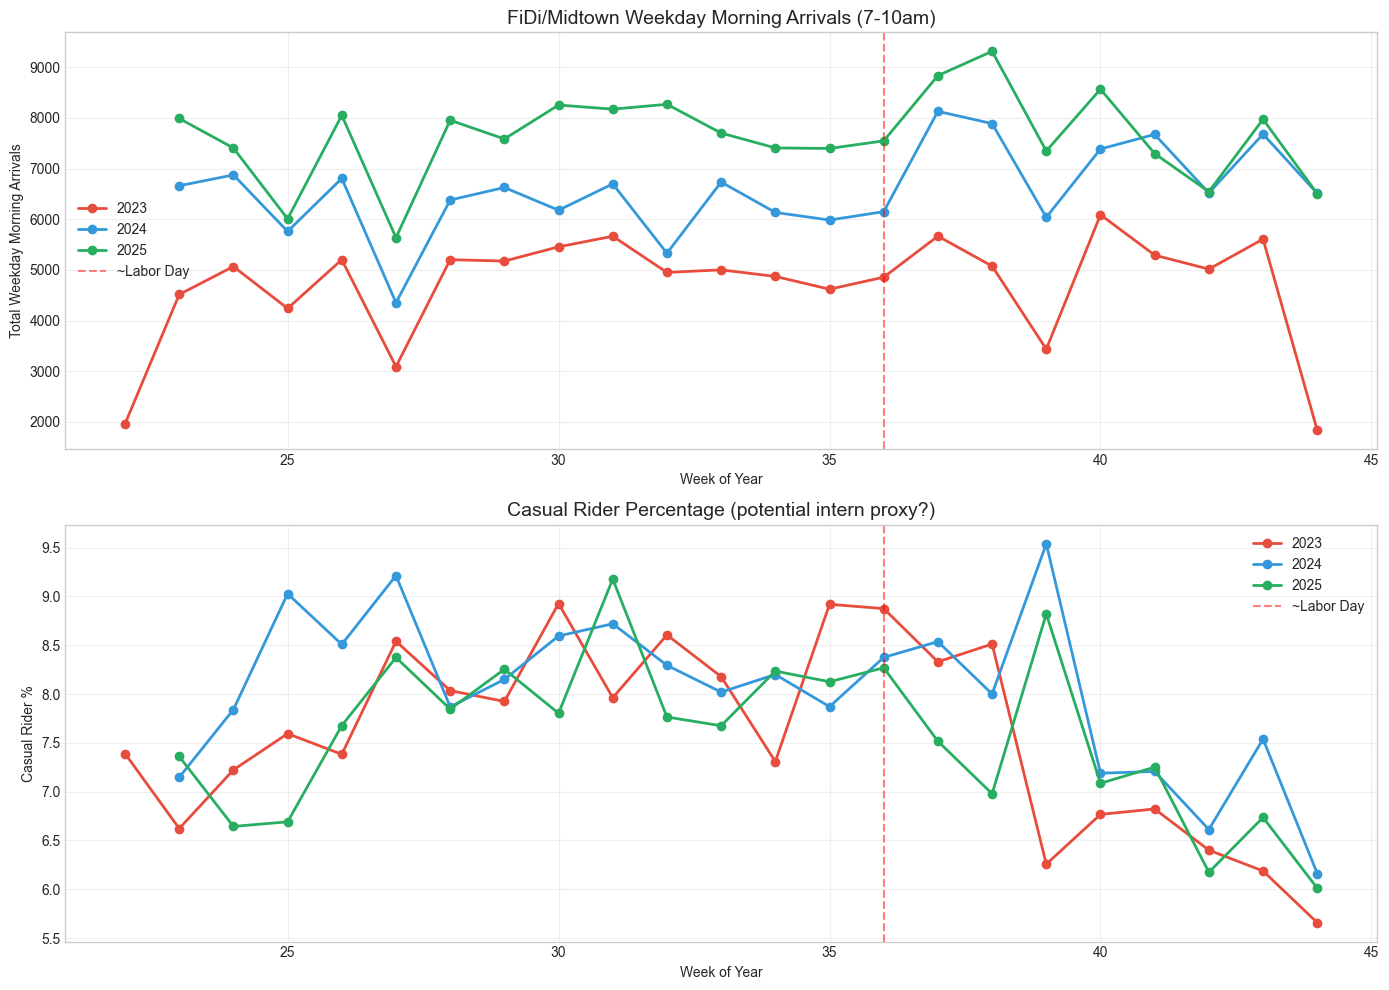

In [14]:
# Plot by year
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

colors = {2023: '#e74c3c', 2024: '#3498db', 2025: '#27ae60'}

for year in [2023, 2024, 2025]:
    year_data = weekly[weekly['year'] == year].copy()
    if len(year_data) == 0:
        continue
    
    # Normalize week_start to week number for comparison
    year_data['week_num'] = year_data['week_start'].dt.isocalendar().week
    
    axes[0].plot(year_data['week_num'], year_data['total_trips'], 
                 'o-', label=str(year), color=colors[year], linewidth=2, markersize=6)
    axes[1].plot(year_data['week_num'], year_data['casual_pct'], 
                 'o-', label=str(year), color=colors[year], linewidth=2, markersize=6)

# Labor Day is typically week 36
for ax in axes:
    ax.axvline(x=36, color='red', linestyle='--', alpha=0.5, label='~Labor Day')
    ax.set_xlabel('Week of Year')
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel('Total Weekday Morning Arrivals')
axes[0].set_title('FiDi/Midtown Weekday Morning Arrivals (7-10am)', fontsize=14)

axes[1].set_ylabel('Casual Rider %')
axes[1].set_title('Casual Rider Percentage (potential intern proxy?)', fontsize=14)

plt.tight_layout()
plt.show()

## 2. July vs September Comparison (The Test)

If the intern pattern exists, we should see:
- FiDi: Casual % drops in September
- Universities: Casual % rises in September (students return)

In [15]:
# Compare July vs September at FiDi and Universities
comparison = con.execute(f"""
    SELECT 
        EXTRACT(YEAR FROM started_at) as year,
        CASE 
            WHEN EXTRACT(MONTH FROM started_at) = 7 THEN 'July'
            WHEN EXTRACT(MONTH FROM started_at) = 9 THEN 'September'
        END as month,
        CASE 
            WHEN end_station_name IN ({FIDI_SQL}) THEN 'FiDi/Midtown'
            WHEN end_station_name IN ({UNI_SQL}) THEN 'Universities'
        END as location,
        COUNT(*) as total,
        COUNT(*) FILTER (WHERE member_casual = 'casual') as casual,
        COUNT(*) FILTER (WHERE member_casual = 'member') as members
    FROM '{DATA_PATH}'
    WHERE EXTRACT(DOW FROM started_at) BETWEEN 1 AND 5
      AND EXTRACT(HOUR FROM started_at) BETWEEN 7 AND 9
      AND EXTRACT(MONTH FROM started_at) IN (7, 9)
    GROUP BY 1, 2, 3
    HAVING location IS NOT NULL
    ORDER BY 1, 3, 2
""").fetchdf()

comparison['casual_pct'] = comparison['casual'] / comparison['total'] * 100

print("Weekday Morning Arrivals - July vs September:")
print("="*80)
print(comparison.to_string(index=False))

Weekday Morning Arrivals - July vs September:
 year     month     location  total  casual  members  casual_pct
 2023      July FiDi/Midtown  19968    1658    18310    8.303285
 2023 September FiDi/Midtown  19660    1613    18047    8.204476
 2023      July Universities   1711     183     1528   10.695500
 2023 September Universities   1581     194     1387   12.270715
 2024      July FiDi/Midtown  27791    2322    25469    8.355223
 2024 September FiDi/Midtown  29631    2518    27113    8.497857
 2024      July Universities   2688     337     2351   12.537202
 2024 September Universities   2626     299     2327   11.386139
 2025      July FiDi/Midtown  35197    2891    32306    8.213768
 2025 September FiDi/Midtown  36762    2851    33911    7.755291
 2025      July Universities   2529     251     2278    9.924871
 2025 September Universities   3451     367     3084   10.634599


In [16]:
# Calculate changes
print("\n" + "="*80)
print("JULY → SEPTEMBER CHANGES")
print("="*80)

for year in comparison['year'].unique():
    print(f"\n--- {int(year)} ---")
    for loc in ['FiDi/Midtown', 'Universities']:
        july = comparison[(comparison['year'] == year) & 
                         (comparison['location'] == loc) & 
                         (comparison['month'] == 'July')]
        sep = comparison[(comparison['year'] == year) & 
                        (comparison['location'] == loc) & 
                        (comparison['month'] == 'September')]
        
        if len(july) == 0 or len(sep) == 0:
            continue
            
        jul_total = july['total'].values[0]
        sep_total = sep['total'].values[0]
        jul_casual = july['casual_pct'].values[0]
        sep_casual = sep['casual_pct'].values[0]
        
        total_chg = (sep_total - jul_total) / jul_total * 100
        casual_chg = sep_casual - jul_casual
        
        print(f"  {loc}:")
        print(f"    Total trips: {jul_total:,} → {sep_total:,} ({total_chg:+.0f}%)")
        print(f"    Casual %:    {jul_casual:.1f}% → {sep_casual:.1f}% ({casual_chg:+.1f}pp)")


JULY → SEPTEMBER CHANGES

--- 2023 ---
  FiDi/Midtown:
    Total trips: 19,968 → 19,660 (-2%)
    Casual %:    8.3% → 8.2% (-0.1pp)
  Universities:
    Total trips: 1,711 → 1,581 (-8%)
    Casual %:    10.7% → 12.3% (+1.6pp)

--- 2024 ---
  FiDi/Midtown:
    Total trips: 27,791 → 29,631 (+7%)
    Casual %:    8.4% → 8.5% (+0.1pp)
  Universities:
    Total trips: 2,688 → 2,626 (-2%)
    Casual %:    12.5% → 11.4% (-1.2pp)

--- 2025 ---
  FiDi/Midtown:
    Total trips: 35,197 → 36,762 (+4%)
    Casual %:    8.2% → 7.8% (-0.5pp)
  Universities:
    Total trips: 2,529 → 3,451 (+36%)
    Casual %:    9.9% → 10.6% (+0.7pp)


## 3. Electric vs Classic Bikes

Maybe interns prefer a certain bike type?

In [17]:
# Bike type analysis
bike_type = con.execute(f"""
    SELECT 
        EXTRACT(YEAR FROM started_at) as year,
        CASE 
            WHEN EXTRACT(MONTH FROM started_at) = 7 THEN 'July'
            WHEN EXTRACT(MONTH FROM started_at) = 9 THEN 'September'
        END as month,
        rideable_type,
        COUNT(*) as trips
    FROM '{DATA_PATH}'
    WHERE end_station_name IN ({FIDI_SQL})
      AND EXTRACT(DOW FROM started_at) BETWEEN 1 AND 5
      AND EXTRACT(HOUR FROM started_at) BETWEEN 7 AND 9
      AND EXTRACT(MONTH FROM started_at) IN (7, 9)
    GROUP BY 1, 2, 3
    ORDER BY 1, 2, 3
""").fetchdf()

# Pivot
pivot = bike_type.pivot_table(index=['year', 'month'], columns='rideable_type', values='trips', fill_value=0)
pivot['total'] = pivot.sum(axis=1)
for col in pivot.columns[:-1]:
    pivot[f'{col}_pct'] = pivot[col] / pivot['total'] * 100

print("Bike Type Mix at FiDi (Weekday Mornings):")
print(pivot.to_string())

Bike Type Mix at FiDi (Weekday Mornings):
rideable_type   classic_bike  electric_bike    total  classic_bike_pct  electric_bike_pct
year month                                                                               
2023 July            11563.0         8405.0  19968.0         57.907652          42.092348
     September       10465.0         9195.0  19660.0         53.229908          46.770092
2024 July            11063.0        16728.0  27791.0         39.807851          60.192149
     September       10662.0        18969.0  29631.0         35.982586          64.017414
2025 July            10105.0        25092.0  35197.0         28.709833          71.290167
     September       10544.0        26218.0  36762.0         28.681791          71.318209


## 4. Trip Duration Analysis

Interns might have different commute patterns (shorter/longer trips?).

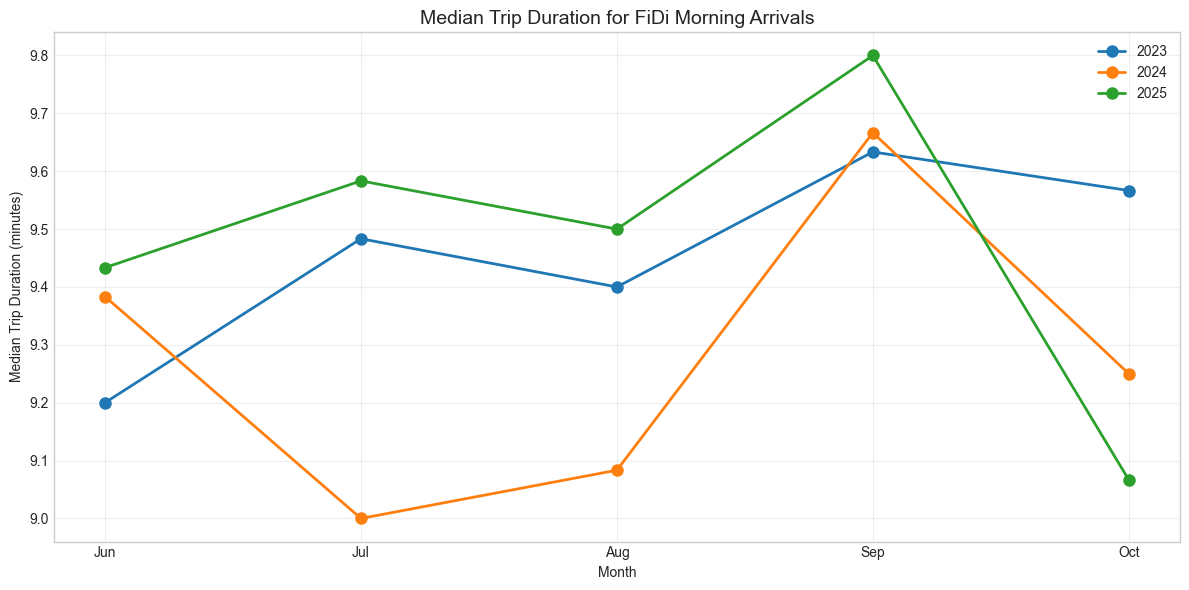


Trip Duration by Month (minutes):
 year  month  median_min   avg_min  trips
 2023      6    9.200000 11.348432  20936
 2023      7    9.483333 11.631275  19875
 2023      8    9.400000 11.575630  23368
 2023      9    9.633333 11.985726  19591
 2023     10    9.566667 11.693580  23762
 2024      6    9.383333 11.610455  26025
 2024      7    9.000000 11.247108  27724
 2024      8    9.083333 11.378197  26553
 2024      9    9.666667 11.853953  29556
 2024     10    9.250000 11.283690  34295
 2025      6    9.433333 11.492214  30768
 2025      7    9.583333 11.645599  35122
 2025      8    9.500000 11.519804  31718
 2025      9    9.800000 11.809014  36684
 2025     10    9.066667 11.017985  33116


In [18]:
# Trip duration by month
duration = con.execute(f"""
    SELECT 
        EXTRACT(YEAR FROM started_at) as year,
        EXTRACT(MONTH FROM started_at) as month,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY duration_sec) as median_duration,
        AVG(duration_sec) as avg_duration,
        COUNT(*) as trips
    FROM '{DATA_PATH}'
    WHERE end_station_name IN ({FIDI_SQL})
      AND EXTRACT(DOW FROM started_at) BETWEEN 1 AND 5
      AND EXTRACT(HOUR FROM started_at) BETWEEN 7 AND 9
      AND EXTRACT(MONTH FROM started_at) BETWEEN 6 AND 10
      AND duration_sec BETWEEN 60 AND 3600
    GROUP BY 1, 2
    ORDER BY 1, 2
""").fetchdf()

duration['median_min'] = duration['median_duration'] / 60
duration['avg_min'] = duration['avg_duration'] / 60

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

month_names = {6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct'}

for year in [2023, 2024, 2025]:
    year_data = duration[duration['year'] == year]
    if len(year_data) == 0:
        continue
    ax.plot(year_data['month'], year_data['median_min'], 'o-', 
            label=str(int(year)), linewidth=2, markersize=8)

ax.set_xticks([6, 7, 8, 9, 10])
ax.set_xticklabels([month_names[m] for m in [6, 7, 8, 9, 10]])
ax.set_xlabel('Month')
ax.set_ylabel('Median Trip Duration (minutes)')
ax.set_title('Median Trip Duration for FiDi Morning Arrivals', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTrip Duration by Month (minutes):")
print(duration[['year', 'month', 'median_min', 'avg_min', 'trips']].to_string(index=False))

## 5. Origin Station Analysis

Do the origins of FiDi trips change between July and September?

In [19]:
# Top origin changes July vs September 2024
origins = con.execute(f"""
    SELECT 
        CASE 
            WHEN EXTRACT(MONTH FROM started_at) = 7 THEN 'July'
            WHEN EXTRACT(MONTH FROM started_at) = 9 THEN 'September'
        END as month,
        start_station_name as origin,
        COUNT(*) as trips
    FROM '../data/processed/*2024*.parquet'
    WHERE end_station_name IN ({FIDI_SQL})
      AND EXTRACT(DOW FROM started_at) BETWEEN 1 AND 5
      AND EXTRACT(HOUR FROM started_at) BETWEEN 7 AND 9
      AND EXTRACT(MONTH FROM started_at) IN (7, 9)
    GROUP BY 1, 2
    HAVING trips >= 50
""").fetchdf()

# Pivot to compare
pivot = origins.pivot(index='origin', columns='month', values='trips').fillna(0)
pivot['change'] = (pivot['September'] - pivot['July']) / pivot['July'] * 100
pivot['change'] = pivot['change'].replace([np.inf, -np.inf], np.nan)

# Biggest increases (maybe student areas?)
print("Origins with BIGGEST INCREASE July→September 2024:")
print("(These might be student/young professional areas)")
print("="*70)
increases = pivot.dropna().nlargest(10, 'change')
for origin, row in increases.iterrows():
    print(f"  {origin[:45]:<45} {row['July']:>5.0f} → {row['September']:>5.0f} ({row['change']:>+.0f}%)")

print("\nOrigins with BIGGEST DECREASE July→September 2024:")
print("(These might have had more interns in summer)")
print("="*70)
decreases = pivot.dropna().nsmallest(10, 'change')
for origin, row in decreases.iterrows():
    print(f"  {origin[:45]:<45} {row['July']:>5.0f} → {row['September']:>5.0f} ({row['change']:>+.0f}%)")

Origins with BIGGEST INCREASE July→September 2024:
(These might be student/young professional areas)
  West End Ave & W 60 St                           81 →   252 (+211%)
  W 44 St & 11 Ave                                165 →   337 (+104%)
  FDR Drive & E 35 St                             104 →   212 (+104%)
  W 64 St & Thelonious Monk Circle                 68 →   129 (+90%)
  Amsterdam Ave & W 66 St                          50 →    94 (+88%)
  Central Park W & W 91 St                         86 →   160 (+86%)
  Lexington Ave & E 24 St                          83 →   151 (+82%)
  2 Ave & E 72 St                                  62 →   110 (+77%)
  Christopher St & Greenwich St                    53 →    93 (+75%)
  Central Park W & W 68 St                         58 →   100 (+72%)

Origins with BIGGEST DECREASE July→September 2024:
(These might have had more interns in summer)
  1 Ave & E 62 St                                  83 →     0 (-100%)
  1 Ave & E 68 St                     

## 6. The Crossover Test (FiDi vs Universities)

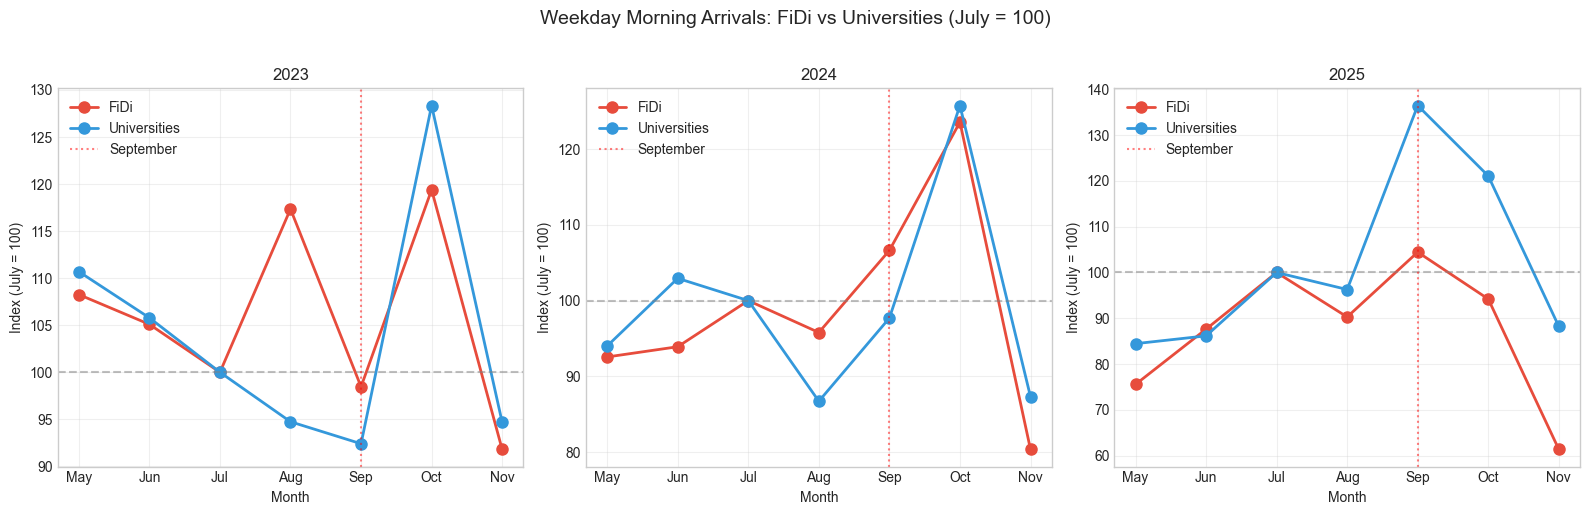

In [20]:
# Monthly pattern at FiDi vs Universities
crossover = con.execute(f"""
    SELECT 
        EXTRACT(YEAR FROM started_at) as year,
        EXTRACT(MONTH FROM started_at) as month,
        CASE 
            WHEN end_station_name IN ({FIDI_SQL}) THEN 'FiDi'
            WHEN end_station_name IN ({UNI_SQL}) THEN 'Universities'
        END as location,
        COUNT(*) as trips
    FROM '{DATA_PATH}'
    WHERE EXTRACT(DOW FROM started_at) BETWEEN 1 AND 5
      AND EXTRACT(HOUR FROM started_at) BETWEEN 7 AND 9
      AND EXTRACT(MONTH FROM started_at) BETWEEN 5 AND 11
    GROUP BY 1, 2, 3
    HAVING location IS NOT NULL
    ORDER BY 1, 3, 2
""").fetchdf()

# Normalize to July for each year/location
def normalize_to_july(df):
    result = []
    for year in df['year'].unique():
        for loc in df['location'].unique():
            subset = df[(df['year'] == year) & (df['location'] == loc)].copy()
            july_val = subset[subset['month'] == 7]['trips'].values
            if len(july_val) > 0:
                subset['indexed'] = subset['trips'] / july_val[0] * 100
                result.append(subset)
    return pd.concat(result)

crossover = normalize_to_july(crossover)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

month_names = {5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov'}

for idx, year in enumerate([2023, 2024, 2025]):
    ax = axes[idx]
    year_data = crossover[crossover['year'] == year]
    
    if len(year_data) == 0:
        ax.text(0.5, 0.5, f'No data for {year}', ha='center', va='center')
        continue
    
    for loc, color in [('FiDi', '#e74c3c'), ('Universities', '#3498db')]:
        loc_data = year_data[year_data['location'] == loc]
        ax.plot(loc_data['month'], loc_data['indexed'], 'o-', 
                label=loc, color=color, linewidth=2, markersize=8)
    
    ax.axhline(y=100, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=9, color='red', linestyle=':', alpha=0.5, label='September')
    ax.set_xticks(range(5, 12))
    ax.set_xticklabels([month_names[m] for m in range(5, 12)])
    ax.set_xlabel('Month')
    ax.set_ylabel('Index (July = 100)')
    ax.set_title(f'{int(year)}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Weekday Morning Arrivals: FiDi vs Universities (July = 100)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [21]:
# Calculate crossover magnitude
print("\nCROSSOVER ANALYSIS: FiDi vs Universities")
print("="*70)
print("(Looking for: FiDi drops in Sep while Universities rise)")
print()

for year in [2023, 2024, 2025]:
    year_data = crossover[crossover['year'] == year]
    if len(year_data) == 0:
        continue
    
    print(f"--- {int(year)} ---")
    for loc in ['FiDi', 'Universities']:
        jul = year_data[(year_data['location'] == loc) & (year_data['month'] == 7)]['indexed'].values
        sep = year_data[(year_data['location'] == loc) & (year_data['month'] == 9)]['indexed'].values
        
        if len(jul) > 0 and len(sep) > 0:
            change = sep[0] - jul[0]
            print(f"  {loc:<15}: Jul={jul[0]:.0f} → Sep={sep[0]:.0f} ({change:+.0f}pp)")
    print()


CROSSOVER ANALYSIS: FiDi vs Universities
(Looking for: FiDi drops in Sep while Universities rise)

--- 2023 ---
  FiDi           : Jul=100 → Sep=98 (-2pp)
  Universities   : Jul=100 → Sep=92 (-8pp)

--- 2024 ---
  FiDi           : Jul=100 → Sep=107 (+7pp)
  Universities   : Jul=100 → Sep=98 (-2pp)

--- 2025 ---
  FiDi           : Jul=100 → Sep=104 (+4pp)
  Universities   : Jul=100 → Sep=136 (+36pp)



## 7. Summary

In [22]:
print("="*70)
print("SUMMARY: Can We Detect Interns in Modern Data?")
print("="*70)
print("""
WITHOUT AGE DATA, we look for proxies:

1. TOTAL VOLUME:
   - FiDi morning arrivals should drop in September if interns leave
   - Universities should increase in September as students return

2. CASUAL vs MEMBER:
   - Interns might be more likely casual riders (short-term NYC residents)
   - If casual % drops in September at FiDi, that could indicate interns

3. ORIGIN STATIONS:
   - Some neighborhoods might show bigger drops (intern housing areas?)

4. THE CROSSOVER TEST:
   - If FiDi drops while Unis rise in September, that's consistent with
     the intern/student pattern we saw in 2017-2019

CAVEAT: Without age data, we can't be certain these patterns are driven
by interns specifically. Other factors (vacation schedules, weather) 
could also contribute.
""")

con.close()

SUMMARY: Can We Detect Interns in Modern Data?

WITHOUT AGE DATA, we look for proxies:

1. TOTAL VOLUME:
   - FiDi morning arrivals should drop in September if interns leave
   - Universities should increase in September as students return

2. CASUAL vs MEMBER:
   - Interns might be more likely casual riders (short-term NYC residents)
   - If casual % drops in September at FiDi, that could indicate interns

3. ORIGIN STATIONS:
   - Some neighborhoods might show bigger drops (intern housing areas?)

4. THE CROSSOVER TEST:
   - If FiDi drops while Unis rise in September, that's consistent with
     the intern/student pattern we saw in 2017-2019

CAVEAT: Without age data, we can't be certain these patterns are driven
by interns specifically. Other factors (vacation schedules, weather) 
could also contribute.

